In [23]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report
from torchsummary import summary


In [24]:
class IVFDataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        # print(y, len(y))
        
        if y is None:
            self.y = y
        else:
            self.y = torch.LongTensor(y)
        self.x = torch.FloatTensor(x)
        
    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [25]:
class DNN_Regression(nn.Module):
    def __init__(self, input_dim):
        super(DNN_Regression, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [26]:
model = DNN_Regression(22)
print(model)

DNN_Regression(
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)


In [27]:
summary(model, (1, 22))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]             368
              ReLU-2                [-1, 1, 16]               0
            Linear-3                 [-1, 1, 8]             136
              ReLU-4                 [-1, 1, 8]               0
            Linear-5                 [-1, 1, 2]              18
Total params: 522
Trainable params: 522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [28]:
train_loss=[] 
val_loss=[]

def trainer(train_loader, valid_loader, model, config, device):
    
    # TODO try differnet criterion or optimizer 
    # criterion = nn.MSELoss(reduction='mean')
    # w=torch.tensor([0.1,0.9])
    # criterion = nn.CrossEntropyLoss(weight=w)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], betas=(0.9, 0.999), eps=1e-08)
    writer = SummaryWriter()
    
    if not os.path.isdir('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models'):
        os.mkdir('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models') # Create directory of saving models.
    
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    
    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)
        train_acc = []
        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            
            loss = criterion(pred, y)
            
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            
            acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()
            train_acc.append(acc)
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
        
        print(f"Train Acc: {sum(train_acc) / len(train_acc)}")
        mean_train_loss = sum(loss_record)/len(loss_record)
        train_loss.append(mean_train_loss)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        val_acc = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
                
                acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()
                val_acc.append(acc)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        val_loss.append(mean_valid_loss)
        print(f"Val Acc: {sum(val_acc) / len(val_acc)}")
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [29]:
device = 'cpu'

config = {
    'seed': 55688,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-4,              
    'early_stop': 20,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': '/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models/model_classification_Adam_SMOTE_20221116.ckpt'  # Your model will be saved here.
}

In [30]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [31]:
same_seed(config['seed'])

In [32]:
train_x = pd.read_csv('../ML_storage/train_binary_x.csv')
train_y = pd.read_csv('../ML_storage/train_binary_y.csv')
test_x = pd.read_csv('../ML_storage/test_binary_x.csv')
test_y = pd.read_csv('../ML_storage/test_binary_y.csv')

In [33]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.10, random_state=42)

In [34]:
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(112338, 20) (112338, 1)
(12482, 20) (12482, 1)
(31205, 20) (31205, 1)


In [35]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state = 100, sampling_strategy = 1.0)
train_x_smt, train_y_smt = smt.fit_resample(train_x, train_y)
print(train_y_smt.value_counts())

LiveBirth
0            98814
1            98814
dtype: int64


In [36]:
#train_x = train_x_smt.to_numpy()
#train_y = train_y_smt.to_numpy().ravel()

train_x = train_x.to_numpy()
train_y = train_y.to_numpy().ravel()
valid_x = valid_x.to_numpy()
valid_y = valid_y.to_numpy().ravel()
test_x  = test_x.to_numpy()
test_y = test_y.to_numpy().ravel()

In [37]:
train_dataset = IVFDataset(train_x, train_y)
valid_dataset = IVFDataset(valid_x, valid_y)
test_dataset = IVFDataset(test_x)

In [38]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

In [39]:
train_loss = []
val_loss = []
model = DNN_Regression(input_dim=train_x.shape[1]).to(device)

In [40]:
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 228.66it/s, loss=0.441]


Train Acc: 0.37265920639038086
Val Acc: 0.8746498823165894
Epoch [1/500]: Train loss: 0.9814, Valid loss: 0.4896
Saving model with loss 0.490...


Epoch [2/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:02<00:00, 219.49it/s, loss=0.351]


Train Acc: 0.8796197175979614
Val Acc: 0.8746753334999084
Epoch [2/500]: Train loss: 0.4058, Valid loss: 0.3832
Saving model with loss 0.383...


Epoch [3/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.32it/s, loss=0.388]


Train Acc: 0.8796060681343079
Val Acc: 0.8745989203453064
Epoch [3/500]: Train loss: 0.3628, Valid loss: 0.3614
Saving model with loss 0.361...


Epoch [4/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 231.01it/s, loss=0.297]


Train Acc: 0.8796324729919434
Val Acc: 0.8743696212768555
Epoch [4/500]: Train loss: 0.3400, Valid loss: 0.3353
Saving model with loss 0.335...


Epoch [5/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:02<00:00, 215.17it/s, loss=0.289]


Train Acc: 0.8804928064346313
Val Acc: 0.8774976134300232
Epoch [5/500]: Train loss: 0.3103, Valid loss: 0.3007
Saving model with loss 0.301...


Epoch [6/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 234.47it/s, loss=0.242]


Train Acc: 0.8867420554161072
Val Acc: 0.8879951238632202
Epoch [6/500]: Train loss: 0.2760, Valid loss: 0.2669
Saving model with loss 0.267...


Epoch [7/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:02<00:00, 213.69it/s, loss=0.264]


Train Acc: 0.8959417939186096
Val Acc: 0.896470844745636
Epoch [7/500]: Train loss: 0.2464, Valid loss: 0.2407
Saving model with loss 0.241...


Epoch [8/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 235.27it/s, loss=0.215]


Train Acc: 0.9015325903892517
Val Acc: 0.9012951254844666
Epoch [8/500]: Train loss: 0.2239, Valid loss: 0.2195
Saving model with loss 0.220...


Epoch [9/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 221.82it/s, loss=0.19]


Train Acc: 0.9070919156074524
Val Acc: 0.907124400138855
Epoch [9/500]: Train loss: 0.2044, Valid loss: 0.2002
Saving model with loss 0.200...


Epoch [10/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 239.05it/s, loss=0.215]


Train Acc: 0.9131386876106262
Val Acc: 0.9144299030303955
Epoch [10/500]: Train loss: 0.1854, Valid loss: 0.1808
Saving model with loss 0.181...


Epoch [11/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 211.00it/s, loss=0.143]


Train Acc: 0.9201748371124268
Val Acc: 0.9256382584571838
Epoch [11/500]: Train loss: 0.1668, Valid loss: 0.1623
Saving model with loss 0.162...


Epoch [12/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 230.31it/s, loss=0.13]


Train Acc: 0.9282315373420715
Val Acc: 0.9268340468406677
Epoch [12/500]: Train loss: 0.1499, Valid loss: 0.1462
Saving model with loss 0.146...


Epoch [13/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.20it/s, loss=0.0851]


Train Acc: 0.9369238615036011
Val Acc: 0.9379725456237793
Epoch [13/500]: Train loss: 0.1356, Valid loss: 0.1328
Saving model with loss 0.133...


Epoch [14/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 212.62it/s, loss=0.143]


Train Acc: 0.9449223875999451
Val Acc: 0.9458836913108826
Epoch [14/500]: Train loss: 0.1246, Valid loss: 0.1227
Saving model with loss 0.123...


Epoch [15/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 221.86it/s, loss=0.102]


Train Acc: 0.9509115815162659
Val Acc: 0.9516202211380005
Epoch [15/500]: Train loss: 0.1166, Valid loss: 0.1156
Saving model with loss 0.116...


Epoch [16/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 207.40it/s, loss=0.113]


Train Acc: 0.9545412063598633
Val Acc: 0.9535079598426819
Epoch [16/500]: Train loss: 0.1110, Valid loss: 0.1111
Saving model with loss 0.111...


Epoch [17/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 218.20it/s, loss=0.0992]


Train Acc: 0.956926703453064
Val Acc: 0.9555773735046387
Epoch [17/500]: Train loss: 0.1072, Valid loss: 0.1077
Saving model with loss 0.108...


Epoch [18/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 201.04it/s, loss=0.0838]


Train Acc: 0.9583701491355896
Val Acc: 0.9571462869644165
Epoch [18/500]: Train loss: 0.1049, Valid loss: 0.1056
Saving model with loss 0.106...


Epoch [19/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 229.36it/s, loss=0.115]


Train Acc: 0.9598661065101624
Val Acc: 0.955574095249176
Epoch [19/500]: Train loss: 0.1033, Valid loss: 0.1047
Saving model with loss 0.105...


Epoch [20/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 215.61it/s, loss=0.0707]


Train Acc: 0.9603404998779297
Val Acc: 0.9590341448783875
Epoch [20/500]: Train loss: 0.1021, Valid loss: 0.1032
Saving model with loss 0.103...


Epoch [21/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 223.09it/s, loss=0.099]


Train Acc: 0.9608952403068542
Val Acc: 0.9574684500694275
Epoch [21/500]: Train loss: 0.1012, Valid loss: 0.1024
Saving model with loss 0.102...


Epoch [22/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.46it/s, loss=0.104]


Train Acc: 0.9611513018608093
Val Acc: 0.958074152469635
Epoch [22/500]: Train loss: 0.1003, Valid loss: 0.1008
Saving model with loss 0.101...


Epoch [23/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 233.08it/s, loss=0.1]


Train Acc: 0.9615675806999207
Val Acc: 0.9601501822471619
Epoch [23/500]: Train loss: 0.0989, Valid loss: 0.0995
Saving model with loss 0.099...


Epoch [24/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 245.00it/s, loss=0.0877]


Train Acc: 0.9618364572525024
Val Acc: 0.960523247718811
Epoch [24/500]: Train loss: 0.0971, Valid loss: 0.0977
Saving model with loss 0.098...


Epoch [25/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 241.97it/s, loss=0.0976]


Train Acc: 0.9620500206947327
Val Acc: 0.9609695672988892
Epoch [25/500]: Train loss: 0.0954, Valid loss: 0.0967
Saving model with loss 0.097...


Epoch [26/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 233.83it/s, loss=0.107]


Train Acc: 0.9622477293014526
Val Acc: 0.9604945182800293
Epoch [26/500]: Train loss: 0.0939, Valid loss: 0.0949
Saving model with loss 0.095...


Epoch [27/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 214.08it/s, loss=0.0696]


Train Acc: 0.9621874094009399
Val Acc: 0.9602299332618713
Epoch [27/500]: Train loss: 0.0928, Valid loss: 0.0942
Saving model with loss 0.094...


Epoch [28/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 231.90it/s, loss=0.0843]


Train Acc: 0.9622674584388733
Val Acc: 0.9600416421890259
Epoch [28/500]: Train loss: 0.0922, Valid loss: 0.0937
Saving model with loss 0.094...


Epoch [29/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 217.19it/s, loss=0.0602]


Train Acc: 0.9622268676757812
Val Acc: 0.9599652290344238
Epoch [29/500]: Train loss: 0.0916, Valid loss: 0.0935
Saving model with loss 0.093...


Epoch [30/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 234.20it/s, loss=0.111]


Train Acc: 0.9623081088066101
Val Acc: 0.9608134031295776
Epoch [30/500]: Train loss: 0.0912, Valid loss: 0.0926
Saving model with loss 0.093...


Epoch [31/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 231.36it/s, loss=0.0722]


Train Acc: 0.9622814059257507
Val Acc: 0.9609728455543518
Epoch [31/500]: Train loss: 0.0907, Valid loss: 0.0922
Saving model with loss 0.092...


Epoch [32/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 254.89it/s, loss=0.127]


Train Acc: 0.9621885418891907
Val Acc: 0.9610812664031982
Epoch [32/500]: Train loss: 0.0904, Valid loss: 0.0920
Saving model with loss 0.092...


Epoch [33/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 228.38it/s, loss=0.0834]


Train Acc: 0.9623069763183594
Val Acc: 0.9602775573730469
Epoch [33/500]: Train loss: 0.0900, Valid loss: 0.0915
Saving model with loss 0.091...


Epoch [34/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 216.99it/s, loss=0.0621]


Train Acc: 0.9623069763183594
Val Acc: 0.9604912400245667
Epoch [34/500]: Train loss: 0.0896, Valid loss: 0.0913
Saving model with loss 0.091...


Epoch [35/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.25it/s, loss=0.0943]


Train Acc: 0.9622388482093811
Val Acc: 0.9605488181114197
Epoch [35/500]: Train loss: 0.0894, Valid loss: 0.0910
Saving model with loss 0.091...


Epoch [36/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 219.76it/s, loss=0.0729]


Train Acc: 0.9622902870178223
Val Acc: 0.9603893756866455
Epoch [36/500]: Train loss: 0.0890, Valid loss: 0.0908
Saving model with loss 0.091...


Epoch [37/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 263.47it/s, loss=0.0252]


Train Acc: 0.9623968005180359
Val Acc: 0.960759162902832
Epoch [37/500]: Train loss: 0.0888, Valid loss: 0.0903
Saving model with loss 0.090...


Epoch [38/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 235.31it/s, loss=0.108]


Train Acc: 0.9623239040374756
Val Acc: 0.9607048630714417
Epoch [38/500]: Train loss: 0.0885, Valid loss: 0.0910


Epoch [39/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 250.99it/s, loss=0.0766]


Train Acc: 0.962320864200592
Val Acc: 0.9608421325683594
Epoch [39/500]: Train loss: 0.0883, Valid loss: 0.0900
Saving model with loss 0.090...


Epoch [40/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.79it/s, loss=0.0928]


Train Acc: 0.9623525738716125
Val Acc: 0.9607558846473694
Epoch [40/500]: Train loss: 0.0881, Valid loss: 0.0898
Saving model with loss 0.090...


Epoch [41/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 243.68it/s, loss=0.0511]


Train Acc: 0.962395966053009
Val Acc: 0.9605742692947388
Epoch [41/500]: Train loss: 0.0879, Valid loss: 0.0900


Epoch [42/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 240.44it/s, loss=0.0556]


Train Acc: 0.9623108506202698
Val Acc: 0.9608355760574341
Epoch [42/500]: Train loss: 0.0877, Valid loss: 0.0895
Saving model with loss 0.089...


Epoch [43/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 235.77it/s, loss=0.0784]


Train Acc: 0.9623258709907532
Val Acc: 0.9599077105522156
Epoch [43/500]: Train loss: 0.0875, Valid loss: 0.0907


Epoch [44/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 267.06it/s, loss=0.067]


Train Acc: 0.9623692631721497
Val Acc: 0.9605709910392761
Epoch [44/500]: Train loss: 0.0874, Valid loss: 0.0895


Epoch [45/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 232.69it/s, loss=0.078]


Train Acc: 0.9623050093650818
Val Acc: 0.9608931541442871
Epoch [45/500]: Train loss: 0.0873, Valid loss: 0.0891
Saving model with loss 0.089...


Epoch [46/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 251.35it/s, loss=0.0718]


Train Acc: 0.9624048471450806
Val Acc: 0.9604690670967102
Epoch [46/500]: Train loss: 0.0872, Valid loss: 0.0894


Epoch [47/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 235.74it/s, loss=0.0627]


Train Acc: 0.9624048471450806
Val Acc: 0.9607369303703308
Epoch [47/500]: Train loss: 0.0870, Valid loss: 0.0890
Saving model with loss 0.089...


Epoch [48/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.92it/s, loss=0.0899]


Train Acc: 0.9623456001281738
Val Acc: 0.960810124874115
Epoch [48/500]: Train loss: 0.0869, Valid loss: 0.0891


Epoch [49/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 226.27it/s, loss=0.073]


Train Acc: 0.9623672962188721
Val Acc: 0.9608931541442871
Epoch [49/500]: Train loss: 0.0868, Valid loss: 0.0888
Saving model with loss 0.089...


Epoch [50/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.85it/s, loss=0.0872]


Train Acc: 0.9623061418533325
Val Acc: 0.9609473943710327
Epoch [50/500]: Train loss: 0.0867, Valid loss: 0.0888
Saving model with loss 0.089...


Epoch [51/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 231.23it/s, loss=0.0738]


Train Acc: 0.9623286724090576
Val Acc: 0.9609950184822083
Epoch [51/500]: Train loss: 0.0865, Valid loss: 0.0884
Saving model with loss 0.088...


Epoch [52/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 257.56it/s, loss=0.0889]


Train Acc: 0.9623336791992188
Val Acc: 0.9607912302017212
Epoch [52/500]: Train loss: 0.0865, Valid loss: 0.0888


Epoch [53/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 241.32it/s, loss=0.0875]


Train Acc: 0.9623258709907532
Val Acc: 0.9609218239784241
Epoch [53/500]: Train loss: 0.0863, Valid loss: 0.0884


Epoch [54/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 230.45it/s, loss=0.0893]


Train Acc: 0.9623595476150513
Val Acc: 0.9609695672988892
Epoch [54/500]: Train loss: 0.0863, Valid loss: 0.0882
Saving model with loss 0.088...


Epoch [55/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 244.59it/s, loss=0.0786]


Train Acc: 0.9623545408248901
Val Acc: 0.9611355662345886
Epoch [55/500]: Train loss: 0.0863, Valid loss: 0.0884


Epoch [56/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 248.74it/s, loss=0.0849]


Train Acc: 0.9623475670814514
Val Acc: 0.9608931541442871
Epoch [56/500]: Train loss: 0.0862, Valid loss: 0.0882


Epoch [57/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 261.76it/s, loss=0.115]


Train Acc: 0.9623249769210815
Val Acc: 0.9608134031295776
Epoch [57/500]: Train loss: 0.0861, Valid loss: 0.0885


Epoch [58/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 230.96it/s, loss=0.115]


Train Acc: 0.9622933268547058
Val Acc: 0.9608166813850403
Epoch [58/500]: Train loss: 0.0860, Valid loss: 0.0883


Epoch [59/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 252.32it/s, loss=0.0966]


Train Acc: 0.962402880191803
Val Acc: 0.9600992202758789
Epoch [59/500]: Train loss: 0.0860, Valid loss: 0.0888


Epoch [60/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 233.76it/s, loss=0.0696]


Train Acc: 0.9623336791992188
Val Acc: 0.9607912302017212
Epoch [60/500]: Train loss: 0.0859, Valid loss: 0.0883


Epoch [61/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 279.53it/s, loss=0.0692]


Train Acc: 0.9623138904571533
Val Acc: 0.9612629413604736
Epoch [61/500]: Train loss: 0.0859, Valid loss: 0.0879
Saving model with loss 0.088...


Epoch [62/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 244.99it/s, loss=0.0994]


Train Acc: 0.9623664617538452
Val Acc: 0.9612884521484375
Epoch [62/500]: Train loss: 0.0858, Valid loss: 0.0878
Saving model with loss 0.088...


Epoch [63/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 223.96it/s, loss=0.0956]


Train Acc: 0.9624009728431702
Val Acc: 0.9608166813850403
Epoch [63/500]: Train loss: 0.0857, Valid loss: 0.0879


Epoch [64/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 253.66it/s, loss=0.104]


Train Acc: 0.9624001383781433
Val Acc: 0.9609506726264954
Epoch [64/500]: Train loss: 0.0857, Valid loss: 0.0880


Epoch [65/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 228.17it/s, loss=0.0951]


Train Acc: 0.9623595476150513
Val Acc: 0.9609473943710327
Epoch [65/500]: Train loss: 0.0856, Valid loss: 0.0881


Epoch [66/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 245.67it/s, loss=0.0977]


Train Acc: 0.9623773097991943
Val Acc: 0.9611256718635559
Epoch [66/500]: Train loss: 0.0855, Valid loss: 0.0876
Saving model with loss 0.088...


Epoch [67/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.35it/s, loss=0.0595]


Train Acc: 0.9624334573745728
Val Acc: 0.9608134031295776
Epoch [67/500]: Train loss: 0.0855, Valid loss: 0.0879


Epoch [68/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 238.75it/s, loss=0.0793]


Train Acc: 0.9623603820800781
Val Acc: 0.9613393545150757
Epoch [68/500]: Train loss: 0.0855, Valid loss: 0.0874
Saving model with loss 0.087...


Epoch [69/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 220.23it/s, loss=0.0919]


Train Acc: 0.9623645544052124
Val Acc: 0.9612087607383728
Epoch [69/500]: Train loss: 0.0854, Valid loss: 0.0876


Epoch [70/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.64it/s, loss=0.0515]


Train Acc: 0.9623445272445679
Val Acc: 0.9612374305725098
Epoch [70/500]: Train loss: 0.0854, Valid loss: 0.0875


Epoch [71/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.25it/s, loss=0.087]


Train Acc: 0.9623990058898926
Val Acc: 0.9610812664031982
Epoch [71/500]: Train loss: 0.0853, Valid loss: 0.0876


Epoch [72/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 245.55it/s, loss=0.0996]


Train Acc: 0.9623595476150513
Val Acc: 0.9609218239784241
Epoch [72/500]: Train loss: 0.0853, Valid loss: 0.0877


Epoch [73/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 244.58it/s, loss=0.0861]


Train Acc: 0.9623684287071228
Val Acc: 0.9610525369644165
Epoch [73/500]: Train loss: 0.0853, Valid loss: 0.0878


Epoch [74/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 231.91it/s, loss=0.111]


Train Acc: 0.9624128937721252
Val Acc: 0.9612884521484375
Epoch [74/500]: Train loss: 0.0853, Valid loss: 0.0874
Saving model with loss 0.087...


Epoch [75/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 265.12it/s, loss=0.0553]


Train Acc: 0.9624137282371521
Val Acc: 0.9610812664031982
Epoch [75/500]: Train loss: 0.0852, Valid loss: 0.0877


Epoch [76/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 230.20it/s, loss=0.0991]


Train Acc: 0.962356448173523
Val Acc: 0.9613393545150757
Epoch [76/500]: Train loss: 0.0851, Valid loss: 0.0873
Saving model with loss 0.087...


Epoch [77/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 245.62it/s, loss=0.092]


Train Acc: 0.9623742699623108
Val Acc: 0.9609252214431763
Epoch [77/500]: Train loss: 0.0852, Valid loss: 0.0877


Epoch [78/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 228.75it/s, loss=0.0854]


Train Acc: 0.9623367190361023
Val Acc: 0.9611355662345886
Epoch [78/500]: Train loss: 0.0851, Valid loss: 0.0877


Epoch [79/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.86it/s, loss=0.0786]


Train Acc: 0.9624168276786804
Val Acc: 0.9610081911087036
Epoch [79/500]: Train loss: 0.0851, Valid loss: 0.0877


Epoch [80/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.72it/s, loss=0.0864]


Train Acc: 0.9623881578445435
Val Acc: 0.9612629413604736
Epoch [80/500]: Train loss: 0.0850, Valid loss: 0.0872
Saving model with loss 0.087...


Epoch [81/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.65it/s, loss=0.0849]


Train Acc: 0.9623990058898926
Val Acc: 0.9609218239784241
Epoch [81/500]: Train loss: 0.0850, Valid loss: 0.0876


Epoch [82/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 241.70it/s, loss=0.127]


Train Acc: 0.9623289108276367
Val Acc: 0.9611355662345886
Epoch [82/500]: Train loss: 0.0850, Valid loss: 0.0874


Epoch [83/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 224.50it/s, loss=0.102]


Train Acc: 0.9624287486076355
Val Acc: 0.961259663105011
Epoch [83/500]: Train loss: 0.0849, Valid loss: 0.0877


Epoch [84/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 251.28it/s, loss=0.109]


Train Acc: 0.9623467326164246
Val Acc: 0.9610747694969177
Epoch [84/500]: Train loss: 0.0849, Valid loss: 0.0873


Epoch [85/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 221.22it/s, loss=0.105]


Train Acc: 0.9623664617538452
Val Acc: 0.9612119793891907
Epoch [85/500]: Train loss: 0.0849, Valid loss: 0.0873


Epoch [86/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 249.64it/s, loss=0.0857]


Train Acc: 0.9623456001281738
Val Acc: 0.9613648056983948
Epoch [86/500]: Train loss: 0.0849, Valid loss: 0.0871
Saving model with loss 0.087...


Epoch [87/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 231.11it/s, loss=0.0703]


Train Acc: 0.9623603820800781
Val Acc: 0.9611577391624451
Epoch [87/500]: Train loss: 0.0849, Valid loss: 0.0873


Epoch [88/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 256.92it/s, loss=0.095]


Train Acc: 0.962397038936615
Val Acc: 0.9609982967376709
Epoch [88/500]: Train loss: 0.0848, Valid loss: 0.0874


Epoch [89/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 229.07it/s, loss=0.0926]


Train Acc: 0.9623951315879822
Val Acc: 0.9608709216117859
Epoch [89/500]: Train loss: 0.0848, Valid loss: 0.0876


Epoch [90/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 249.39it/s, loss=0.0932]


Train Acc: 0.9623881578445435
Val Acc: 0.9609728455543518
Epoch [90/500]: Train loss: 0.0847, Valid loss: 0.0873


Epoch [91/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 244.60it/s, loss=0.0716]


Train Acc: 0.9623920321464539
Val Acc: 0.9611290097236633
Epoch [91/500]: Train loss: 0.0848, Valid loss: 0.0874


Epoch [92/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 243.37it/s, loss=0.0488]


Train Acc: 0.9623998403549194
Val Acc: 0.9611101150512695
Epoch [92/500]: Train loss: 0.0847, Valid loss: 0.0874


Epoch [93/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.13it/s, loss=0.0802]


Train Acc: 0.9623881578445435
Val Acc: 0.9609982967376709
Epoch [93/500]: Train loss: 0.0847, Valid loss: 0.0873


Epoch [94/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 226.91it/s, loss=0.0725]


Train Acc: 0.9624295830726624
Val Acc: 0.9612119793891907
Epoch [94/500]: Train loss: 0.0847, Valid loss: 0.0871


Epoch [95/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.94it/s, loss=0.101]


Train Acc: 0.9623931646347046
Val Acc: 0.9610525369644165
Epoch [95/500]: Train loss: 0.0847, Valid loss: 0.0872


Epoch [96/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.22it/s, loss=0.1]


Train Acc: 0.9623872637748718
Val Acc: 0.9609506726264954
Epoch [96/500]: Train loss: 0.0847, Valid loss: 0.0875


Epoch [97/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 249.88it/s, loss=0.105]


Train Acc: 0.9623931646347046
Val Acc: 0.9609506726264954
Epoch [97/500]: Train loss: 0.0846, Valid loss: 0.0878


Epoch [98/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 230.06it/s, loss=0.0924]


Train Acc: 0.9624168276786804
Val Acc: 0.9611865282058716
Epoch [98/500]: Train loss: 0.0846, Valid loss: 0.0873


Epoch [99/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 248.06it/s, loss=0.0777]


Train Acc: 0.9624187350273132
Val Acc: 0.961259663105011
Epoch [99/500]: Train loss: 0.0846, Valid loss: 0.0870
Saving model with loss 0.087...


Epoch [100/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 226.47it/s, loss=0.0716]


Train Acc: 0.9624009728431702
Val Acc: 0.9609728455543518
Epoch [100/500]: Train loss: 0.0846, Valid loss: 0.0872


Epoch [101/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 248.56it/s, loss=0.0736]


Train Acc: 0.9623672962188721
Val Acc: 0.9611068367958069
Epoch [101/500]: Train loss: 0.0846, Valid loss: 0.0872


Epoch [102/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 241.64it/s, loss=0.0605]


Train Acc: 0.9623712301254272
Val Acc: 0.9610525369644165
Epoch [102/500]: Train loss: 0.0846, Valid loss: 0.0873


Epoch [103/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.37it/s, loss=0.0759]


Train Acc: 0.962402880191803
Val Acc: 0.9610081911087036
Epoch [103/500]: Train loss: 0.0845, Valid loss: 0.0875


Epoch [104/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 251.06it/s, loss=0.0644]


Train Acc: 0.9624009728431702
Val Acc: 0.9610270857810974
Epoch [104/500]: Train loss: 0.0845, Valid loss: 0.0873


Epoch [105/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 230.01it/s, loss=0.109]


Train Acc: 0.962419867515564
Val Acc: 0.9612119793891907
Epoch [105/500]: Train loss: 0.0845, Valid loss: 0.0871


Epoch [106/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 249.38it/s, loss=0.0806]


Train Acc: 0.9623672962188721
Val Acc: 0.9611831903457642
Epoch [106/500]: Train loss: 0.0845, Valid loss: 0.0870


Epoch [107/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 224.31it/s, loss=0.0787]


Train Acc: 0.9623831510543823
Val Acc: 0.9611610174179077
Epoch [107/500]: Train loss: 0.0845, Valid loss: 0.0872


Epoch [108/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.30it/s, loss=0.0939]


Train Acc: 0.9624148607254028
Val Acc: 0.9612884521484375
Epoch [108/500]: Train loss: 0.0845, Valid loss: 0.0870


Epoch [109/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 225.44it/s, loss=0.0791]


Train Acc: 0.962390124797821
Val Acc: 0.9610525369644165
Epoch [109/500]: Train loss: 0.0844, Valid loss: 0.0873


Epoch [110/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 256.55it/s, loss=0.118]


Train Acc: 0.9623200297355652
Val Acc: 0.9611577391624451
Epoch [110/500]: Train loss: 0.0845, Valid loss: 0.0871


Epoch [111/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 245.97it/s, loss=0.0856]


Train Acc: 0.9623920321464539
Val Acc: 0.9612374305725098
Epoch [111/500]: Train loss: 0.0845, Valid loss: 0.0871


Epoch [112/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 248.75it/s, loss=0.0836]


Train Acc: 0.9623386859893799
Val Acc: 0.9611610174179077
Epoch [112/500]: Train loss: 0.0844, Valid loss: 0.0873


Epoch [113/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.00it/s, loss=0.0907]


Train Acc: 0.9624098539352417
Val Acc: 0.9610780477523804
Epoch [113/500]: Train loss: 0.0844, Valid loss: 0.0874


Epoch [114/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 226.00it/s, loss=0.125]


Train Acc: 0.9623664617538452
Val Acc: 0.9612374305725098
Epoch [114/500]: Train loss: 0.0844, Valid loss: 0.0871


Epoch [115/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 250.76it/s, loss=0.108]


Train Acc: 0.9623556137084961
Val Acc: 0.9610270857810974
Epoch [115/500]: Train loss: 0.0844, Valid loss: 0.0872


Epoch [116/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 226.98it/s, loss=0.0881]


Train Acc: 0.9623703956604004
Val Acc: 0.9611068367958069
Epoch [116/500]: Train loss: 0.0844, Valid loss: 0.0872


Epoch [117/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.49it/s, loss=0.077]


Train Acc: 0.9624078869819641
Val Acc: 0.9610525369644165
Epoch [117/500]: Train loss: 0.0844, Valid loss: 0.0872


Epoch [118/500]: 100%|███████████████████████████████████████████████████| 439/439 [00:01<00:00, 224.89it/s, loss=0.0589]


Train Acc: 0.962408721446991
Val Acc: 0.9611577391624451
Epoch [118/500]: Train loss: 0.0844, Valid loss: 0.0871


Epoch [119/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 272.79it/s, loss=0.104]


Train Acc: 0.9623861908912659
Val Acc: 0.9611034989356995
Epoch [119/500]: Train loss: 0.0843, Valid loss: 0.0873

Model is not improving, so we halt the training session.


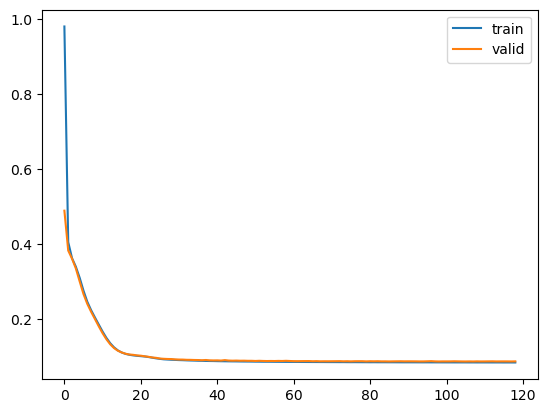

In [41]:
from matplotlib import pyplot
pyplot.plot(train_loss, label='train')
pyplot.plot(val_loss, label='valid')
pyplot.legend()
pyplot.show()

In [42]:
model = DNN_Regression(input_dim=train_x.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
print(preds)

100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 1364.48it/s]

[[ 7.517808  -6.835399 ]
 [ 5.805566  -5.397224 ]
 [ 5.5932417 -5.0461283]
 ...
 [ 6.9670563 -6.180004 ]
 [ 8.025436  -7.427295 ]
 [ 6.5177584 -5.83995  ]]


In [43]:
from scipy.special import softmax

fp = open("result-DNNAdamSMOTE-0.962388.txt", 'w')

fp.write("index, score\n")
for index, pred in enumerate(preds):
    fp.write(f"{index}, {softmax(pred)[1]}\n")
    

In [18]:
prediction = []
for i in preds:
    if i[0] > i[1]:
        prediction.append(0)
    else:
        prediction.append(1)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_train_x = pca.fit_transform(train_x)

pca_test_x = pca.transform(test_x)

df = pd.DataFrame(pca_test_x)
df['y'] = prediction
df['groundTrue'] = test_y
df

,0,y,groundTrue
0,2.518758,0,0
1,2.633924,0,0
2,5.037992,0,0
3,7.563413,0,0
4,2.510550,0,0
...,...,...,...
31200,-7.454380,0,0
31201,-7.409502,1,1
31202,5.092651,0,0
31203,2.531582,0,0


/tmp/ipykernel_27735/920653628.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot: xlabel='0', ylabel='y'>

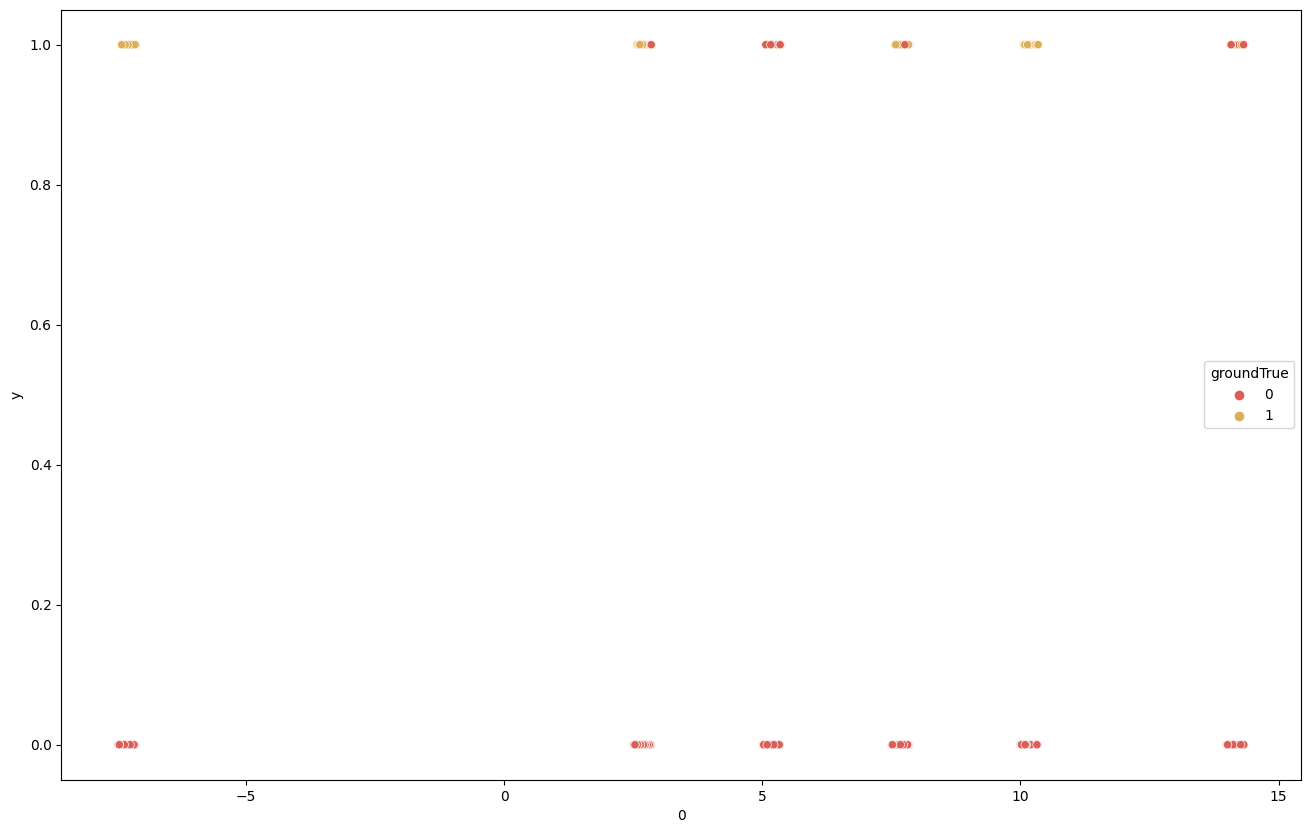

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y='y',
    hue="groundTrue",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=1
)

In [21]:
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     27490
           1       0.76      1.00      0.86      3715

    accuracy                           0.96     31205
   macro avg       0.88      0.98      0.92     31205
weighted avg       0.97      0.96      0.96     31205



In [25]:
from sklearn.metrics import det_curve
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from matplotlib import pyplot as plt
import matplotlib
import bob.measure

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def DETCurve(fps,fns):
    """
    Given false positive and false negative rates, produce a DET Curve.
    The false positive rate is assumed to be increasing while the false
    negative rate is assumed to be decreasing.
    """
    axis_min = min(fps[0],fns[-1])
    fig, ax = plt.subplots()
    plt.plot(fps,fns)
    plt.yscale('log')
    plt.xscale('log')
    ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50]
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    plt.axis([0.001,50,0.001,50])

def generate_det_curve(p_scores, n_scores):
        #matplotlib.use('TkAgg')

        plt.switch_backend('agg')
        bob.measure.plot.det(n_scores, p_scores, 1000, color = (0,0,0), linestyle = '-')
        bob.measure.plot.det_axis([0.01, 99, 0.01, 99])
        threshold = bob.measure.eer_threshold(n_scores, p_scores)
        far, frr = bob.measure.farfrr(n_scores, p_scores, threshold)
        
        print(far, frr)
        x = range(99)
        ax = plt.gca()
        #ax.plot(x)
        ax.set_aspect('equal', adjustable='box')
        plt.plot([100, -10], [100, -10], linestyle='--', label=f"Equal error rate = {max(far, frr)* 100}%")
        print("##########")
        print(max(far, frr) * 100)
        print("##########")
        plt.xlabel('FAR (%)')
        plt.ylabel('FRR (%)')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend(loc="lower right")
        
        plt.savefig('fig/det_SMOTE.png')
        plt.cla()
        plt.clf()
        
        return max(far, frr) * 100


In [23]:
prob_prediction = []
scores = []
for i in preds:
    scores.append(softmax(i)[1])
    prob_prediction.append(i[1])
    
scores = np.array(scores)
fpr, fnr, thresholds = det_curve(test_y, prob_prediction)
print(scores)

[4.4118959e-05 2.8317492e-05 2.2002807e-05 ... 3.8593640e-05 4.0565337e-05
 1.8857802e-04]


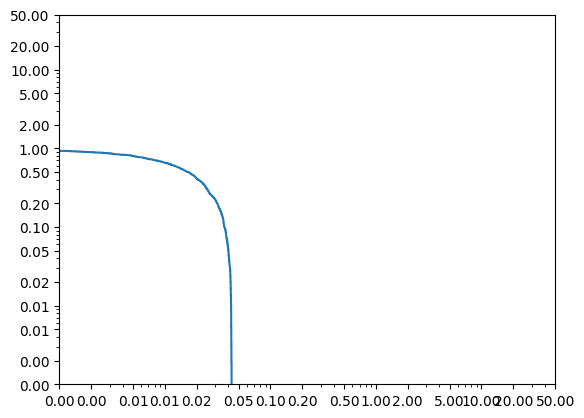

In [24]:
DETCurve(fpr, fnr)

In [26]:
labels = test_y

p_scores, n_scores = scores[np.where(labels == True)].astype(np.double), scores[np.where(labels == False)[0]].astype(np.double)

In [27]:
print(p_scores, n_scores)

generate_det_curve(p_scores, n_scores)

[0.95394832 0.80419391 0.96677178 ... 0.95829731 0.93076634 0.93410748] [4.41189586e-05 2.83174923e-05 2.20028069e-05 ... 3.85936401e-05
 4.05653373e-05 1.88578022e-04]
0.040341942524554385 0.040376850605652756
##########
4.037685060565275
##########


4.037685060565275

KeyboardInterrupt: 